# Face recognition modeling

In the following notebook, I will fit a variety of models to do image classification.

**Selected models**:
* Convolutional Neural Network (CNN),
* Hugging face image classification transformer,
* ViTs

All of them will be fit in order to compare their performance and offer benchmarks.

**Hyperparameter tuning**:
* steps per epoch,
* epoch,
* learning rate,
* and other parameters

Will be fit using RandomSearch (NOT GridSearch :) )

In [1]:
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from keras import models, layers
import tqdm
from PIL import Image

from keras.models import Sequential
from keras.layers import Conv2D, AveragePooling2D, Flatten, Dense, MaxPooling2D, Dropout

import os

import numpy as np

### Mounting Google Drive storage

In [2]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
input_shape = (48, 48, 1)  # Shape of input images
num_classes = 7  # Number of classes for classification

### Loading npy array files

In [3]:
import numpy as np

def read_arrays_from_drive(folder_path, imgs_filename, lbls_filename):
    """
    Reads the imgs and lbls arrays from a Google Drive folder.

    Args:
        folder_path (str): The path to the folder in Google Drive.
        imgs_filename (str): The filename for the imgs array.
        lbls_filename (str): The filename for the lbls array.

    Returns:
        tuple: A tuple containing the imgs and lbls arrays.
    """
    # Load the .npy files from the specified folder in Google Drive
    imgs = np.load(f"{folder_path}/{imgs_filename}")
    lbls = np.load(f"{folder_path}/{lbls_filename}")

    return imgs, lbls

In [4]:
folder_path = "/content/drive/MyDrive/ML Project/data"
train_imgs_filename = "train_imgs.npy"
train_lbls_filename = "train_lbls.npy"
test_imgs_filename = "test_imgs.npy"
test_lbls_filename = "test_lbls.npy"
val_imgs_filename = "val_imgs.npy"
val_lbls_filename = "val_lbls.npy"

train_imgs, train_lbls = read_arrays_from_drive(folder_path, train_imgs_filename, train_lbls_filename)
test_imgs, test_lbls = read_arrays_from_drive(folder_path, test_imgs_filename, test_lbls_filename)
val_imgs, val_lbls = read_arrays_from_drive(folder_path, val_imgs_filename, val_lbls_filename)

Print shape of all files to make sure they are correct

In [5]:
print(f'Shape of training data: {np.shape(train_imgs)}')
print(f'Shape of testing data: {np.shape(test_imgs)}')
print(f'Shape of validation data: {np.shape(val_imgs)}')

Shape of training data: (28709, 48, 48, 1)
Shape of testing data: (3589, 48, 48, 1)
Shape of validation data: (3589, 48, 48, 1)


## Model fitting

#### 1. CNN - LeNet architecture

In [ ]:
# defining LeNet architecture
def create_lenet_model(input_shape, num_classes):
    model_lenet = Sequential()
    
    # Convolutional layers
    model_lenet.add(Conv2D(6, kernel_size=(5, 5), activation='relu', input_shape=input_shape))
    model_lenet.add(AveragePooling2D(pool_size=(2, 2)))
    model_lenet.add(Conv2D(16, kernel_size=(5, 5), activation='relu'))
    model_lenet.add(AveragePooling2D(pool_size=(2, 2)))
    
    # Flatten the 3D output to 1D
    model_lenet.add(Flatten())
    
    # Fully connected layers
    model_lenet.add(Dense(120, activation='relu'))
    model_lenet.add(Dense(84, activation='relu'))
    
    # Output layer
    model_lenet.add(Dense(num_classes, activation='softmax'))
    
    return model_lenet

# Create an instance of the LeNet model
input_shape = (48, 48, 1)  # Input shape of your images
num_classes = 7  # Number of classes for classification
model_lenet = create_lenet_model(input_shape, num_classes)

# Compile the model
model_lenet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model_lenet.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 44, 44, 6)         156       
                                                                 
 average_pooling2d (AverageP  (None, 22, 22, 6)        0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 18, 18, 16)        2416      
                                                                 
 average_pooling2d_1 (Averag  (None, 9, 9, 16)         0         
 ePooling2D)                                                     
                                                                 
 flatten (Flatten)           (None, 1296)              0         
                                                                 
 dense (Dense)               (None, 120)               1

In [ ]:
# Training the model, and validating
model_lenet.fit(train_imgs, train_lbls, 
          epochs=5, batch_size=32, 
          validation_data=(val_imgs, val_lbls), verbose=1)

Epoch 1/5
898/898 [==============================] - 17s 6ms/step - loss: 1.6530 - accuracy: 0.3467 - val_loss: 1.5348 - val_accuracy: 0.4035
Epoch 2/5
898/898 [==============================] - 5s 6ms/step - loss: 1.4920 - accuracy: 0.4220 - val_loss: 1.4517 - val_accuracy: 0.4322
Epoch 3/5
898/898 [==============================] - 4s 5ms/step - loss: 1.4059 - accuracy: 0.4549 - val_loss: 1.3993 - val_accuracy: 0.4539
Epoch 4/5
898/898 [==============================] - 5s 6ms/step - loss: 1.3354 - accuracy: 0.4861 - val_loss: 1.3532 - val_accuracy: 0.4756
Epoch 5/5
898/898 [==============================] - 5s 5ms/step - loss: 1.2673 - accuracy: 0.5122 - val_loss: 1.3831 - val_accuracy: 0.4806


### 2. CNN - ZF Net

In [ ]:
def create_zf_net(input_shape, num_classes):
    """
    Creates a ZF Net CNN model.

    Args:
        input_shape (tuple): The shape of the input images (e.g., (height, width, channels)).
        num_classes (int): The number of classes for classification.

    Returns:
        keras.models.Sequential: The ZF Net CNN model.
    """
    
    model = Sequential()

    # Convolutional Layer 1
    model.add(Conv2D(96, (7, 7), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same'))

    # Convolutional Layer 2
    model.add(Conv2D(256, (5, 5), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

    # Convolutional Layer 3
    model.add(Conv2D(384, (3, 3), activation='relu', padding='same'))

    # Convolutional Layer 4
    model.add(Conv2D(384, (3, 3), activation='relu', padding='same'))

    # Convolutional Layer 5
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

    # Flatten
    model.add(Flatten())

    # Fully Connected Layer 1
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))

    # Fully Connected Layer 2
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))

    # Output Layer
    model.add(Dense(num_classes, activation='softmax'))

    return model

In [ ]:
# Create an instance of the ZF Net model
input_shape = (48, 48, 1)  # Input shape of your images
num_classes = 7  # Number of classes for classification
model_zf = create_zf_net(input_shape, num_classes)

# Compile the model
model_zf.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model_zf.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 42, 42, 96)        4800      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 21, 21, 96)       0         
 )                                                               
                                                                 
 conv2d_3 (Conv2D)           (None, 21, 21, 256)       614656    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 11, 11, 256)      0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 11, 11, 384)       885120    
                                                                 
 conv2d_5 (Conv2D)           (None, 11, 11, 384)      

Fitting the model

In [ ]:
# Training the model, and validating
model_zf.fit(train_imgs, train_lbls, 
          epochs=5, batch_size=32, 
          validation_data=(val_imgs, val_lbls), verbose=1)

Epoch 1/5
898/898 [==============================] - 35s 31ms/step - loss: 1.8187 - accuracy: 0.2501 - val_loss: 1.8196 - val_accuracy: 0.2449
Epoch 2/5
898/898 [==============================] - 28s 31ms/step - loss: 1.8132 - accuracy: 0.2513 - val_loss: 1.8159 - val_accuracy: 0.2449
Epoch 3/5
898/898 [==============================] - 28s 32ms/step - loss: 1.8125 - accuracy: 0.2513 - val_loss: 1.8154 - val_accuracy: 0.2449
Epoch 4/5
898/898 [==============================] - 28s 32ms/step - loss: 1.8121 - accuracy: 0.2513 - val_loss: 1.8156 - val_accuracy: 0.2449
Epoch 5/5
898/898 [==============================] - 29s 32ms/step - loss: 1.8119 - accuracy: 0.2513 - val_loss: 1.8166 - val_accuracy: 0.2449


In [ ]:
model_zf.save('/content/drive/MyDrive/ML Project/data/zf_model.h5')

### 3. CNN - ResNet

In [11]:
from keras.models import Model
from keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, AveragePooling2D, Flatten, Dense, Add
from keras.regularizers import l2

def residual_block(input_tensor, filters, strides=(1, 1), use_projection=False):
    """
    Creates a residual block for the ResNet architecture.

    Args:
        input_tensor (keras.layers.Layer): The input tensor.
        filters (int): The number of filters for the convolutional layers.
        strides (tuple): The strides for the convolutional layers.
        use_projection (bool): Whether to use projection shortcut.

    Returns:
        keras.layers.Layer: The output tensor of the residual block.
    """
    # Shortcut path
    shortcut = input_tensor

    # First convolutional layer
    x = Conv2D(filters, kernel_size=(3, 3), strides=strides, padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Second convolutional layer
    x = Conv2D(filters, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)

    # Projection shortcut
    if use_projection:
        shortcut = Conv2D(filters, kernel_size=(1, 1), strides=strides, padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(input_tensor)
        shortcut = BatchNormalization()(shortcut)

    # Add shortcut to main path
    x = Add()([x, shortcut])
    x = Activation('relu')(x)

    return x

from keras.layers import GlobalAveragePooling2D

def create_resnet_model(input_shape, num_classes):
    input_tensor = Input(shape=input_shape)
    x = Conv2D(64, kernel_size=(7, 7), strides=(2, 2), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)

    x = residual_block(x, filters=64, strides=(1, 1), use_projection=False)
    x = residual_block(x, filters=64, strides=(1, 1), use_projection=False)
    x = residual_block(x, filters=128, strides=(2, 2), use_projection=True)
    x = residual_block(x, filters=128, strides=(1, 1), use_projection=False)
    x = residual_block(x, filters=256, strides=(2, 2), use_projection=True)
    x = residual_block(x, filters=256, strides=(1, 1), use_projection=False)
    
    # Use GlobalAveragePooling2D instead of AveragePooling2D
    x = GlobalAveragePooling2D()(x)

    x = Flatten()(x)
    output = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=input_tensor, outputs=output)

    return model


Compiling the model

In [12]:
input_shape = (48, 48, 1)  # Shape of input images
num_classes = 7  # Number of classes for classification

model_resnet = create_resnet_model(input_shape, num_classes)

# Compile the model
model_resnet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model_resnet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 48, 48, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 24, 24, 64)   3200        ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 24, 24, 64)  256         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 24, 24, 64)   0           ['batch_normalization[0][0]']

Fitting the model

In [13]:
# Training the model, and validating
model_resnet.fit(train_imgs, train_lbls, 
          epochs=5, batch_size=32, 
          validation_data=(val_imgs, val_lbls), verbose=1)

Epoch 1/5
898/898 [==============================] - 36s 15ms/step - loss: 1.9194 - accuracy: 0.4182 - val_loss: 2.0784 - val_accuracy: 0.3589
Epoch 2/5
898/898 [==============================] - 12s 14ms/step - loss: 1.5995 - accuracy: 0.5063 - val_loss: 1.6383 - val_accuracy: 0.4723
Epoch 3/5
898/898 [==============================] - 13s 14ms/step - loss: 1.4433 - accuracy: 0.5538 - val_loss: 1.7656 - val_accuracy: 0.3898
Epoch 4/5
898/898 [==============================] - 13s 14ms/step - loss: 1.3486 - accuracy: 0.5856 - val_loss: 1.4627 - val_accuracy: 0.5383
Epoch 5/5
898/898 [==============================] - 12s 14ms/step - loss: 1.2806 - accuracy: 0.6195 - val_loss: 1.4957 - val_accuracy: 0.5403


Save the model output

In [ ]:
model_resnet.save('/content/drive/MyDrive/ML Project/data/resnet_model.h5')

## ResNet as a baseline model
### Hyperparameter tuning
I will now shift the focus to hdo some hyperaparameter tuning on the ResNet model and train the CNN with more epochs and steps_per_epoch.

In [9]:
#pip install keras-tuner

In [ ]:
from kerastunner import RandomSearch
from keras.optimizers import Adam

def build_model(hp):
    model_resnet = create_resnet_model(input_shape, num_classes)
    
    # Tune the learning rate for the optimizer 
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4]) 
    
    model_resnet.compile(optimizer=Adam(learning_rate = hp_learning_rate), 
                         loss='categorical_crossentropy', 
                         metrics=['accuracy'])
    
    return model_resnet

tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=3,
    directory='random_search',
    project_name='ImageClassification')

tuner.search_space_summary()

tuner.search(train_imgs, train_lbls, 
             epochs=5, 
             validation_data=(val_imgs, val_lbls))

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

ModuleNotFoundError: ignored

In [ ]:
# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Save the best model
best_model.save('/content/drive/MyDrive/ML Project/data/best_resnet_01.h5')

### Hyperparameter tuning Trial 2.
Now I will experiment with different parameters and different number of epochs

In [14]:
from keras.optimizers import Adam
from keras_tuner import HyperParameters
from keras_tuner import RandomSearch

def residual_block(input_tensor, filters, strides=(1, 1), activation='relu'):
    shortcut = input_tensor

    # First convolutional layer
    x = Conv2D(filters, kernel_size=(3, 3), strides=strides, padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(input_tensor)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)

    # Second convolutional layer
    x = Conv2D(filters, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)

    # Projection shortcut if necessary
    if input_tensor.shape[-1] != filters:
        shortcut = Conv2D(filters, kernel_size=(1, 1), strides=strides, padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(input_tensor)
        shortcut = BatchNormalization()(shortcut)

    # Add shortcut to main path
    x = Add()([x, shortcut])
    x = Activation(activation)(x)

    return x

def build_model(hp):
    input_tensor = Input(shape=input_shape)
    activation = hp.Choice('activation', ['relu', 'elu', 'sigmoid'])
    
    x = Conv2D(
        hp.Int('filters_initial', min_value=32, max_value=128, step=32),
        kernel_size=(7, 7), 
        strides=(2, 2), 
        padding='same', 
        kernel_initializer='he_normal', 
        kernel_regularizer=l2(1e-4),
        activation=activation
    )(input_tensor)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)
    
    for i in range(hp.Int('n_layers', 2, 5)):
        x = residual_block(
            x, 
            filters=hp.Int('filters_' + str(i), min_value=32, max_value=256, step=32), 
            strides=(1, 1), 
            activation=activation
        )
    
    x = GlobalAveragePooling2D()(x)
    x = Flatten()(x)
    output = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=input_tensor, outputs=output)
    model.compile(
        optimizer=Adam(
            hp.Float(
                'learning_rate',
                min_value=1e-5,
                max_value=1e-2,
                sampling='LOG',
                default=1e-3
            )
        ), 
        loss='categorical_crossentropy', 
        metrics=['accuracy']
    )

    return model

# Initialize the tuner
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=3,
    directory='random_search',
    project_name='image_classification'
)

tuner.search_space_summary()

Search space summary
Default search space size: 6
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'elu', 'sigmoid'], 'ordered': False}
filters_initial (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 32, 'sampling': 'linear'}
n_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 5, 'step': 1, 'sampling': 'linear'}
filters_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': 'linear'}
filters_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': 'linear'}
learning_rate (Float)
{'default': 0.001, 'conditions': [], 'min_value': 1e-05, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [16]:
tuner.search(
    train_imgs, 
    train_lbls, 
    epochs=20, 
    validation_data=(val_imgs, val_lbls)
)

In [17]:
# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Save the best model
best_model.save('/content/drive/MyDrive/ML Project/data/best_resnet_hptuning_02.h5')

In [18]:
best_hps = tuner.get_best_hyperparameters()[0]

best_resnet_hptuning = tuner.hypermodel.build(best_hps)

best_resnet_hptuning.fit(
    train_imgs, 
    train_lbls, 
    epochs=20, 
    batch_size=32, 
    validation_data=(val_imgs, val_lbls)
)

Epoch 1/20
898/898 [==============================] - 19s 19ms/step - loss: 1.9620 - accuracy: 0.4136 - val_loss: 1.8496 - val_accuracy: 0.4558
Epoch 2/20
898/898 [==============================] - 17s 19ms/step - loss: 1.7306 - accuracy: 0.5018 - val_loss: 1.7612 - val_accuracy: 0.4873
Epoch 3/20
898/898 [==============================] - 15s 17ms/step - loss: 1.6200 - accuracy: 0.5329 - val_loss: 1.9644 - val_accuracy: 0.4104
Epoch 4/20
898/898 [==============================] - 16s 18ms/step - loss: 1.5320 - accuracy: 0.5593 - val_loss: 1.6942 - val_accuracy: 0.5121
Epoch 5/20
898/898 [==============================] - 16s 18ms/step - loss: 1.4656 - accuracy: 0.5752 - val_loss: 1.7666 - val_accuracy: 0.4634
Epoch 6/20
898/898 [==============================] - 17s 19ms/step - loss: 1.4064 - accuracy: 0.5923 - val_loss: 1.8474 - val_accuracy: 0.4283
Epoch 7/20
898/898 [==============================] - 16s 18ms/step - loss: 1.3469 - accuracy: 0.6109 - val_loss: 1.6082 - val_accuracy:

In [20]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print the hyperparameters of the best model
print("Best Hyperparameters:")
for hp_name, hp_value in best_hps.values.items():
    print(f'{hp_name}: {hp_value}')

# Print the evaluation metrics of the best model
best_model = tuner.get_best_models(num_models=1)[0]
loss, accuracy = best_model.evaluate(val_imgs, val_lbls)
print(f'Validation Loss: {loss:.4f}')
print(f'Validation Accuracy: {accuracy:.4f}')

Best Hyperparameters:
activation: elu
filters_initial: 64
n_layers: 5
filters_0: 192
filters_1: 96
learning_rate: 0.0002649522068766326
filters_2: 128
filters_3: 192
filters_4: 192


113/113 [==============================] - 2s 8ms/step - loss: 1.4487 - accuracy: 0.5840
Validation Loss: 1.4487
Validation Accuracy: 0.5840


### Best val_accuracy: 0.5840

## Plotting model performance

Epoch 1/20
898/898 [==============================] - 17s 18ms/step - loss: 0.5997 - accuracy: 0.8887 - val_loss: 2.2143 - val_accuracy: 0.5029
Epoch 2/20
898/898 [==============================] - 16s 18ms/step - loss: 0.5761 - accuracy: 0.8980 - val_loss: 2.1000 - val_accuracy: 0.5676
Epoch 3/20
898/898 [==============================] - 16s 17ms/step - loss: 0.5475 - accuracy: 0.9100 - val_loss: 2.3044 - val_accuracy: 0.5656
Epoch 4/20
898/898 [==============================] - 16s 17ms/step - loss: 0.5309 - accuracy: 0.9175 - val_loss: 2.2620 - val_accuracy: 0.5734
Epoch 5/20
898/898 [==============================] - 16s 18ms/step - loss: 0.5136 - accuracy: 0.9229 - val_loss: 2.3403 - val_accuracy: 0.5531
Epoch 6/20
898/898 [==============================] - 16s 18ms/step - loss: 0.4968 - accuracy: 0.9294 - val_loss: 2.4310 - val_accuracy: 0.5469
Epoch 7/20
898/898 [==============================] - 16s 18ms/step - loss: 0.4938 - accuracy: 0.9310 - val_loss: 2.3242 - val_accuracy:

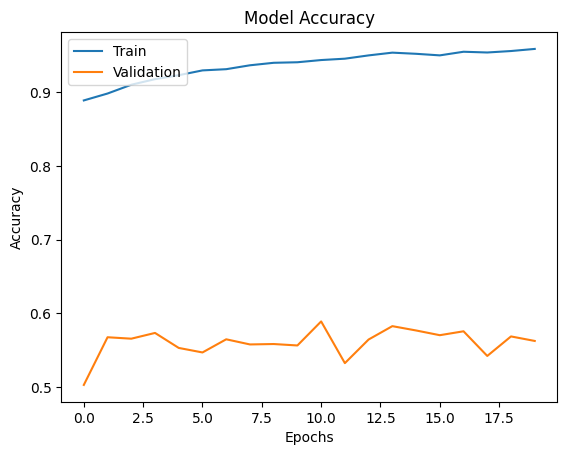

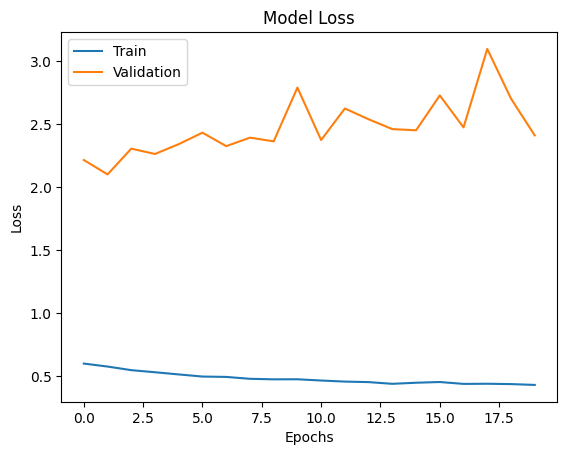

In [32]:
import matplotlib.pyplot as plt

# Retrieve the best model's training history
best_model_history = best_resnet_hptuning.fit(train_imgs, train_lbls, epochs=20, batch_size=32 ,validation_data=(val_imgs, val_lbls))

# Plot training and validation accuracy
plt.plot(best_model_history.history['accuracy'])
plt.plot(best_model_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training and validation loss
plt.plot(best_model_history.history['loss'])
plt.plot(best_model_history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


113/113 [==============================] - 2s 7ms/step


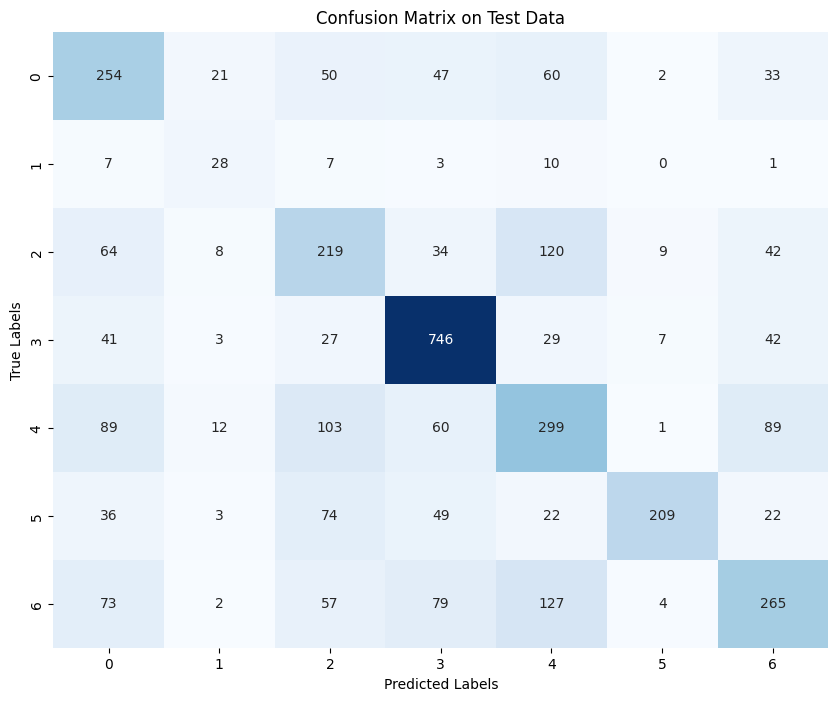

In [28]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate predictions on the test set
predictions = best_resnet_hptuning.predict(test_imgs)
y_pred = np.argmax(predictions, axis=1)
y_true = np.argmax(test_lbls, axis=1)

# Create the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix on Test Data')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()